<h1 class='font-effect-3d' style='font-family:Akronim; color:#ff55ee'> Modules, Helpful Functions, & Styling</h1>

In [1]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Akronim|Roboto&effect=3d');
span {color:black; text-shadow:3px 3px 3px #aaa;}
div.output_prompt {color:darkblue;} 
div.input_prompt {color:#ff55ee;} 
div.output_area pre,div.output_subarea,div.output_stderr pre  
      {background-color:ghostwhite; font-size:15px; color:darkblue;}
</style>

In [2]:
import warnings; warnings.filterwarnings('ignore')
import numpy as np,pandas as pd,pylab as pl
import glob
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential,Model
from keras.optimizers import SGD,RMSprop,Adam,Nadam
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense,Dropout,LSTM
from keras.layers import Activation,Flatten,Input,BatchNormalization
from keras.layers import Conv1D,MaxPooling1D,Conv2D,MaxPooling2D
from keras.layers import GlobalAveragePooling2D,GlobalMaxPooling2D

Using TensorFlow backend.


In [3]:
path='../input/svhn-preproccessed-fragments/'
fw='weights.housenumbers.hdf5'
glob.glob(path+'*')

['../input/svhn-preproccessed-fragments/train_labels.csv',
 '../input/svhn-preproccessed-fragments/test_images.csv',
 '../input/svhn-preproccessed-fragments/extra_labels_2.csv',
 '../input/svhn-preproccessed-fragments/test_labels_2.csv',
 '../input/svhn-preproccessed-fragments/test_labels.csv',
 '../input/svhn-preproccessed-fragments/housenumbers',
 '../input/svhn-preproccessed-fragments/extra_images.csv',
 '../input/svhn-preproccessed-fragments/extra_labels.csv',
 '../input/svhn-preproccessed-fragments/test_images_2.csv',
 '../input/svhn-preproccessed-fragments/train_images_2.csv',
 '../input/svhn-preproccessed-fragments/extra_images_2.csv',
 '../input/svhn-preproccessed-fragments/train_images.csv',
 '../input/svhn-preproccessed-fragments/train_labels_2.csv']

<h1 class='font-effect-3d' style='font-family:Akronim; color:#ff55ee'> Data Loading & Preprocessing</h1>

Label:  [10 10 10  4  1]
[[0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0]]


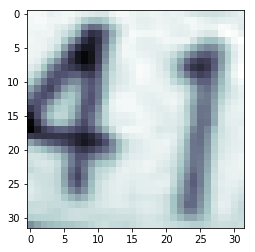

In [4]:
train_images=pd.read_csv(path+'train_images.csv')
train_labels=pd.read_csv(path+'train_labels.csv')
test_images=pd.read_csv(path+'test_images.csv')
test_labels=pd.read_csv(path+'test_labels.csv')
extra_images=pd.read_csv(path+'extra_images.csv')
extra_labels=pd.read_csv(path+'extra_labels.csv')
train_images=train_images.iloc[:,1:]\
.as_matrix().astype('float32').reshape(-1,32,32,1)
train_labels=train_labels.iloc[:,1:]\
.as_matrix().astype('int16')
test_images=test_images.iloc[:,1:]\
.as_matrix().astype('float32').reshape(-1,32,32,1)
test_labels=test_labels.iloc[:,1:]\
.as_matrix().astype('int16')
extra_images=extra_images.iloc[:,1:]\
.as_matrix().astype('float32').reshape(-1,32,32,1)
extra_labels=extra_labels.iloc[:,1:]\
.as_matrix().astype('int16')
ctrain_labels=to_categorical(train_labels,num_classes=11)\
.astype('int16')
ctest_labels=to_categorical(test_labels,num_classes=11)\
.astype('int16')
cextra_labels=to_categorical(extra_labels,num_classes=11)\
.astype('int16')
n=np.random.randint(1,2000,1)[0]
print('Label: ',train_labels[n])
print(ctrain_labels[n])
pl.imshow(train_images[n].reshape(32,32),
          cmap=pl.cm.bone);

In [5]:
X=np.concatenate((train_images,
                        test_images),axis=0)
X=np.concatenate((X,extra_images),axis=0)
y=np.concatenate((ctrain_labels,
                  ctest_labels),axis=0)
y=np.concatenate((y,cextra_labels),axis=0)
def tts(X,y): 
    x_train,x_test,y_train,y_test=\
    train_test_split(X,y,test_size=.2,random_state=1)
    n=int(len(x_test)/2)
    x_valid,y_valid=x_test[:n],y_test[:n]
    x_test,y_test=x_test[n:],y_test[n:]
    return x_train,x_valid,x_test,y_train,y_valid,y_test
x_train,x_valid,x_test,\
y_train,y_valid,y_test=tts(X,y)
y_train_list=[y_train[:,i] for i in range(5)]
y_test_list=[y_test[:,i] for i in range(5)]
y_valid_list=[y_valid[:,i] for i in range(5)]
for el in [x_train,x_valid,x_test,
           y_train,y_valid,y_test]:
    print(el.shape)

(25600, 32, 32, 1)
(3200, 32, 32, 1)
(3200, 32, 32, 1)
(25600, 5, 11)
(3200, 5, 11)
(3200, 5, 11)


<h1 class='font-effect-3d' style='font-family:Akronim; color:#ff55ee'>Build the Model</h1>

In [6]:
def cnn_model():    
    model_input=Input(shape=(32,32,1))
    x=BatchNormalization()(model_input)        
    x=Conv2D(32,(3,3),activation='relu',
             padding='same')(model_input)
    x=MaxPooling2D(pool_size=(2,2))(x)     
    x=Conv2D(32,(3,3),activation='relu')(x)
    x=MaxPooling2D(pool_size=(2,2))(x)    
    x=Dropout(.25)(x)    
    x=Conv2D(64,(3,3),activation='relu')(x)       
    x=Conv2D(64,(3,3),activation='relu')(x)    
    x=Dropout(.25)(x)    
    x=Conv2D(196,(3,3),activation='relu')(x)    
    x=Dropout(.25)(x)              
    x=Flatten()(x)    
    x=Dense(512,activation='relu')(x)    
    x=Dropout(.5)(x)    
    y=[Dense(11,activation='softmax')(x)
       for i in range(5)]    
    model=Model(input=model_input,output=y)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])
    return model
cnn_model=cnn_model()

In [7]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,
                             save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=10,
                               verbose=2,factor=.75)
estopping=EarlyStopping(monitor='val_loss',patience=16,verbose=2)
history=cnn_model.fit(x_train,y_train_list,
                      validation_data=(x_valid,y_valid_list), 
                      epochs=200,batch_size=128,verbose=2, 
                      callbacks=[checkpointer,lr_reduction,estopping])

Train on 25600 samples, validate on 3200 samples
Epoch 1/200
 - 10s - loss: 6.6318 - dense_2_loss: 0.0783 - dense_3_loss: 0.3399 - dense_4_loss: 1.4832 - dense_5_loss: 2.3732 - dense_6_loss: 2.3572 - dense_2_acc: 0.9935 - dense_3_acc: 0.9435 - dense_4_acc: 0.5892 - dense_5_acc: 0.1336 - dense_6_acc: 0.1029 - val_loss: 6.2072 - val_dense_2_loss: 0.0070 - val_dense_3_loss: 0.2593 - val_dense_4_loss: 1.3356 - val_dense_5_loss: 2.3010 - val_dense_6_loss: 2.3043 - val_dense_2_acc: 0.9997 - val_dense_3_acc: 0.9437 - val_dense_4_acc: 0.5859 - val_dense_5_acc: 0.1528 - val_dense_6_acc: 0.1053

Epoch 00001: val_loss improved from inf to 6.20717, saving model to weights.housenumbers.hdf5
Epoch 2/200
 - 3s - loss: 5.9737 - dense_2_loss: 0.0074 - dense_3_loss: 0.2218 - dense_4_loss: 1.2176 - dense_5_loss: 2.2210 - dense_6_loss: 2.3058 - dense_2_acc: 0.9996 - dense_3_acc: 0.9493 - dense_4_acc: 0.6130 - dense_5_acc: 0.1835 - dense_6_acc: 0.1280 - val_loss: 5.7072 - val_dense_2_loss: 0.0025 - val_den

In [8]:
cnn_model.load_weights(fw)
cnn_scores=cnn_model.evaluate(x_test,y_test_list,verbose=0)
print("CNN. Scores: \n" ,(cnn_scores))
print("First digit. Accuracy: %.2f%%"%(cnn_scores[6]*100))
print("Second digit. Accuracy: %.2f%%"%(cnn_scores[7]*100))
print("Third digit. Accuracy: %.2f%%"%(cnn_scores[8]*100))
print("Fourth digit. Accuracy: %.2f%%"%(cnn_scores[9]*100))
print("Fifth digit. Accuracy: %.2f%%"%(cnn_scores[10]*100))
avg_accuracy=sum([cnn_scores[i] for i in range(6,11)])/5
print("CNN Model. Average Accuracy: %.2f%%"%(avg_accuracy*100))

CNN. Scores: 
 [0.8458517909049987, 0.003209494865044462, 0.037595245342529324, 0.19342281268909572, 0.2875651360675693, 0.32405910827219486, 0.9996875, 0.99, 0.9459375, 0.9228125, 0.90625]
First digit. Accuracy: 99.97%
Second digit. Accuracy: 99.00%
Third digit. Accuracy: 94.59%
Fourth digit. Accuracy: 92.28%
Fifth digit. Accuracy: 90.62%
CNN Model. Average Accuracy: 95.29%


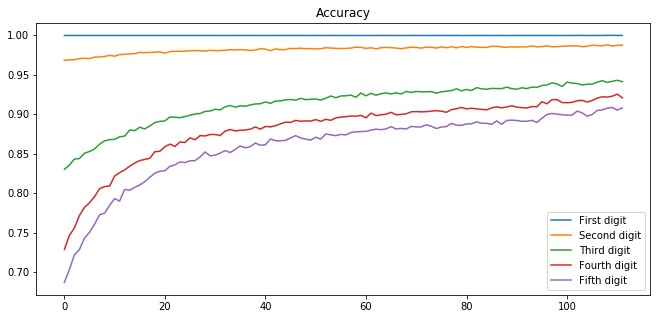

In [9]:
pl.figure(figsize=(11,5)); k=10
keys=list(history.history.keys())[17:]
pl.plot(history.history[keys[0]][k:],label='First digit')
pl.plot(history.history[keys[1]][k:],label='Second digit')
pl.plot(history.history[keys[2]][k:],label='Third digit')
pl.plot(history.history[keys[3]][k:],label='Fourth digit')
pl.plot(history.history[keys[4]][k:],label='Fifth digit')
pl.legend(); pl.title('Accuracy');